# 04 - Clustering

In [47]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping
import pandas as pd
import os
import matplotlib.animation as animation

from models.X_RCC import XRCC#, XRCC_silhouette
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
from IPython.display import display

In [48]:
# -- FREE PARAMETERS
n_seasons   = 2
n_iters     = 100

learning_rate   = 1
min_len         = 30
mode            = 'single'
starting_bp     = [165, 264]

overwrite_results = True

In [49]:
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Path for results
results_path_file   = f'../data/results/netcdf_files/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.nc'
results_path_image  = f'../data/results/images/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.png'

if os.path.exists(results_path_file) and overwrite_results:
    results_exist = True
    print('Results already stored! - Overwriting')

if os.path.exists(results_path_file) and not overwrite_results:
    results_exist = True
    print('Results already stored! - Skipping clustering')

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')

In [50]:
if not os.path.exists(results_path_file) or overwrite_results:

    dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load()
    dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load()


    dataset_tp['time'] = dataset_t2m['time']

    datasets = [dataset_tp, dataset_t2m]  # Add as many datasets as needed

    clustering_params = {
        'iters': n_iters,
        'n_seas': n_seasons,
        'learning_rate': learning_rate,
        'min_len': min_len,
        'mode': mode,
        'starting_bp': starting_bp,
    }

    breakpoints, error_history_da, silhouette_scores_da = XRCC(datasets, **clustering_params)

else:
    result = xr.open_dataset(results_path_file).__xarray_dataarray_variable__

....................................................

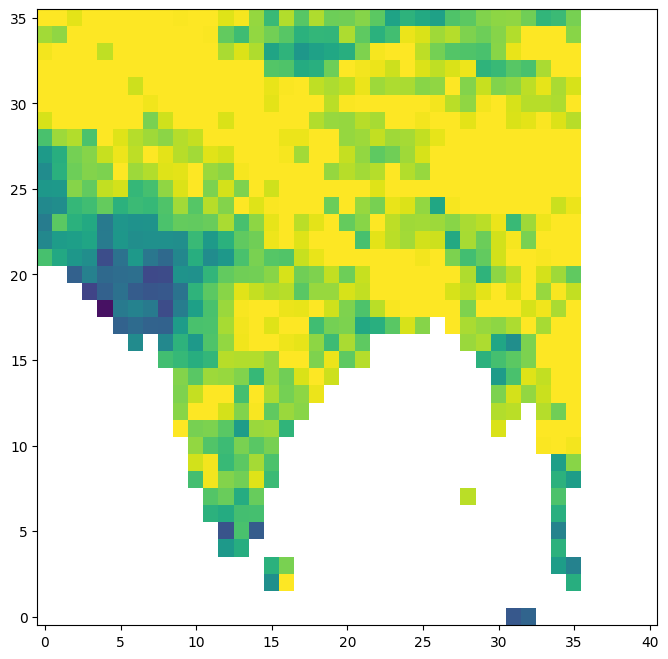

In [52]:
fps = 2
nSeconds = n_iters

array_3d  = error_history_da.to_numpy()
snapshots = [array_3d [:, :, i] for i in range(array_3d .shape[2])]

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = snapshots[0]
im = plt.imshow(a, interpolation='none', aspect='auto', origin = 'lower', vmin=1200, vmax=1700)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = n_iters,
                               interval = 1000 / fps, # in ms
                               )

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

In [55]:
xr.merge([dataset_t2m.isel(time=0), breakpoints.isel(cluster=0).rename('onset')]).to_netcdf('p.nc')

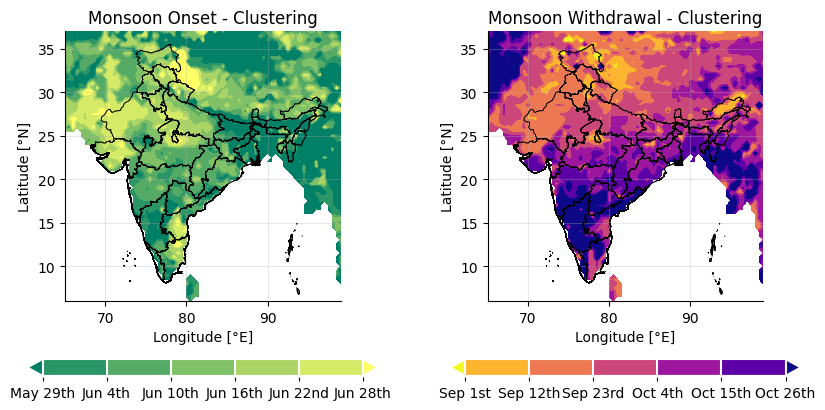

In [5]:
# Load country boundary data
# mask_boundary = gpd.read_file(world_boundary_file, layer='ADM_1')
# mask_boundary = mask_boundary[mask_boundary["GID_0"].isin(['IND','NPL','BGD'])]

# result_plot = result.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
# result_plot.rio.write_crs("epsg:4326", inplace=True)
# result_plot = result_plot.rio.clip(mask_boundary.geometry.apply(mapping), mask_boundary.crs, drop=True)

result_plot = result


plot_seasons_bk_results( result_plot, figsize=(10,5), cmaps=['summer', 'plasma_r'],
                         lims=[[150,180],[245,300]], titles=['Monsoon Onset - Clustering', 'Monsoon Withdrawal - Clustering'],
                         country_boundary=country_boundary, world_boundary=country_boundary)

# plt.savefig(results_path_image, dpi=300, bbox_inches='tight', transparent=False)

In [6]:
if not os.path.exists(results_path_file) or overwrite_results:
    
    result.attrs=dict(
            Description="Dataset with seasonal onset dates obtained with Radially Constrained Clustering",
            Parameters=(

                f"Number of seasons: {n_seasons}",
                f"Number of iterations: {n_iters}",
                f"Learning rate: {learning_rate}",
                f"Minimum length of seasons: {min_len}",
                f"Clustering mode: {mode}",
                f"Initializtion dates: {[day_of_year_to_date(x) for x in starting_bp]}",
        
            )
        )

    result.to_netcdf(results_path_file)